In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers

2024-04-21 07:43:56.539776: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 07:43:56.539914: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 07:43:56.659206: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 32
CHANNELS = 3
EPOCHS = 100

In [3]:
ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/cifar10-augmented-all/images_mixed/train",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 66000 files belonging to 10 classes.


In [4]:
class_names = ds.class_names
class_names

['Airplane',
 'Automobile',
 'Bird',
 'Cat',
 'Deer',
 'Dog',
 'Frog',
 'Horse',
 'Ship',
 'Truck']

(32, 32, 32, 3)


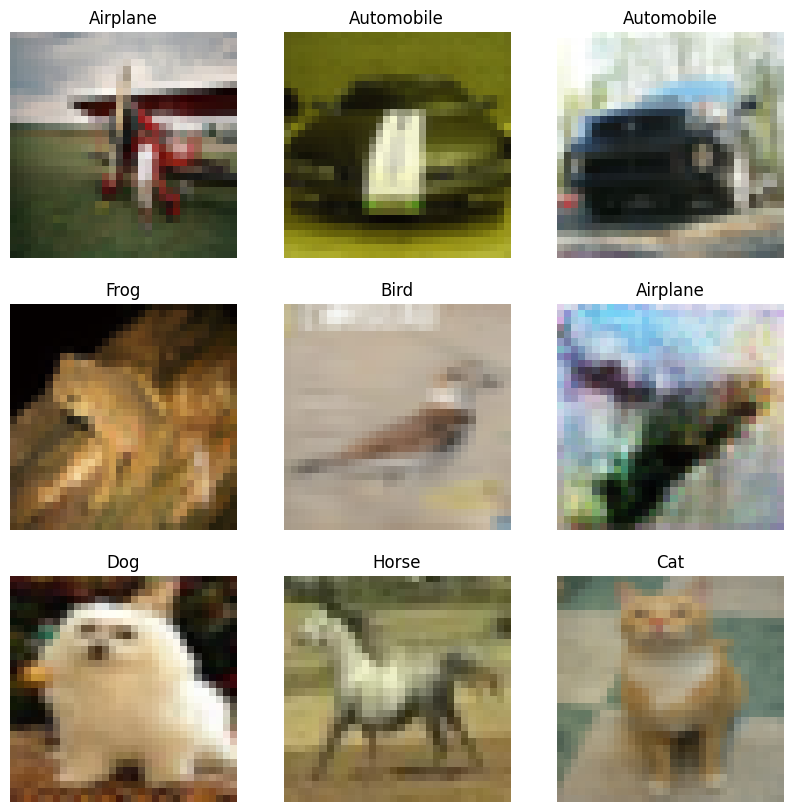

In [5]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in ds.take(1):
    print(image_batch.shape)
    for i in range(0,9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [6]:
len(ds)

2063

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(ds)

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
from tensorflow.keras.layers import Resizing, Rescaling

resize_and_rescale = tf.keras.Sequential([
  Resizing(IMAGE_SIZE, IMAGE_SIZE),
  Rescaling(1./255),
])

In [11]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomContrast(0.2),
  layers.RandomZoom(0.2)
])


In [12]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

# Build the model
model.build(input_shape=(None, *input_shape))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [13]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 2, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 1, 1, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,914 (671.54 KB)

 Trainable params: 171,914 (671.54 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [15]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/100
1650/1650 ━━━━━━━━━━━━━━━━━━━━ 105s 18ms/step - accuracy: 0.2068 - loss: 2.0731 - val_accuracy: 0.3683 - val_loss: 1.7016
Epoch 2/100
1650/1650 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.3538 - loss: 1.7657 - val_accuracy: 0.4125 - val_loss: 1.6064
Epoch 3/100
1650/1650 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.4071 - loss: 1.6278 - val_accuracy: 0.4380 - val_loss: 1.5356
Epoch 4/100
1650/1650 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.4305 - loss: 1.5763 - val_accuracy: 0.4754 - val_loss: 1.4468
Epoch 5/100
1650/1650 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.4475 - loss: 1.5224 - val_accuracy: 0.4983 - val_loss: 1.3720
Epoch 6/100
1650/1650 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.4686 - loss: 1.4760 - val_accuracy: 0.4968 - val_loss: 1.3805
Epoch 7/100
1650/1650 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.4786 - loss: 1.4482 - val_accuracy: 0.5308 - val_loss: 1.2865
Epoch 8/100
1650/1650 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.4867

In [16]:
scores = model.evaluate(test_ds)

207/207 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - accuracy: 0.6638 - loss: 0.9774


In [17]:
scores

[1.0019891262054443, 0.6592693328857422]

In [18]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 1650}

In [19]:
history.history["loss"]

[1.9632936716079712,
 1.7248855829238892,
 1.616172432899475,
 1.5566579103469849,
 1.5054980516433716,
 1.4691863059997559,
 1.4385993480682373,
 1.408441185951233,
 1.3867295980453491,
 1.3663469552993774,
 1.3398579359054565,
 1.3323806524276733,
 1.3185133934020996,
 1.3045316934585571,
 1.2928529977798462,
 1.2785265445709229,
 1.2664551734924316,
 1.2544209957122803,
 1.2457894086837769,
 1.2391517162322998,
 1.2297406196594238,
 1.2241291999816895,
 1.2098287343978882,
 1.2127668857574463,
 1.2115583419799805,
 1.2025822401046753,
 1.1945033073425293,
 1.1939756870269775,
 1.1789754629135132,
 1.17837393283844,
 1.1766465902328491,
 1.1751729249954224,
 1.160968542098999,
 1.1641963720321655,
 1.1574110984802246,
 1.155930757522583,
 1.1493669748306274,
 1.141767978668213,
 1.1395126581192017,
 1.1404459476470947,
 1.1321470737457275,
 1.1303534507751465,
 1.1281787157058716,
 1.1290537118911743,
 1.1272460222244263,
 1.119877815246582,
 1.1114226579666138,
 1.1144851446151733,


In [20]:
history.history["accuracy"]

[0.2584116458892822,
 0.3702637255191803,
 0.4126439690589905,
 0.4387882649898529,
 0.45405805110931396,
 0.4713360071182251,
 0.4824378490447998,
 0.4912284016609192,
 0.5008146166801453,
 0.5099083185195923,
 0.5226394534111023,
 0.5236624479293823,
 0.5291565656661987,
 0.5321120023727417,
 0.5386291146278381,
 0.5443126559257507,
 0.5493520498275757,
 0.5528379678726196,
 0.5569301247596741,
 0.5593172311782837,
 0.5618368983268738,
 0.5641672015190125,
 0.5709306001663208,
 0.5698506832122803,
 0.5709874033927917,
 0.573488175868988,
 0.5774287581443787,
 0.5776182413101196,
 0.5823544859886169,
 0.5808199644088745,
 0.581142008304596,
 0.5838132500648499,
 0.5883601307868958,
 0.5880759358406067,
 0.5904251337051392,
 0.5914860367774963,
 0.5943278074264526,
 0.5964686274528503,
 0.5971695780754089,
 0.5976811051368713,
 0.6017353534698486,
 0.6010723114013672,
 0.6005418300628662,
 0.6017164587974548,
 0.6052212715148926,
 0.6037245988845825,
 0.6059033274650574,
 0.60789257287

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

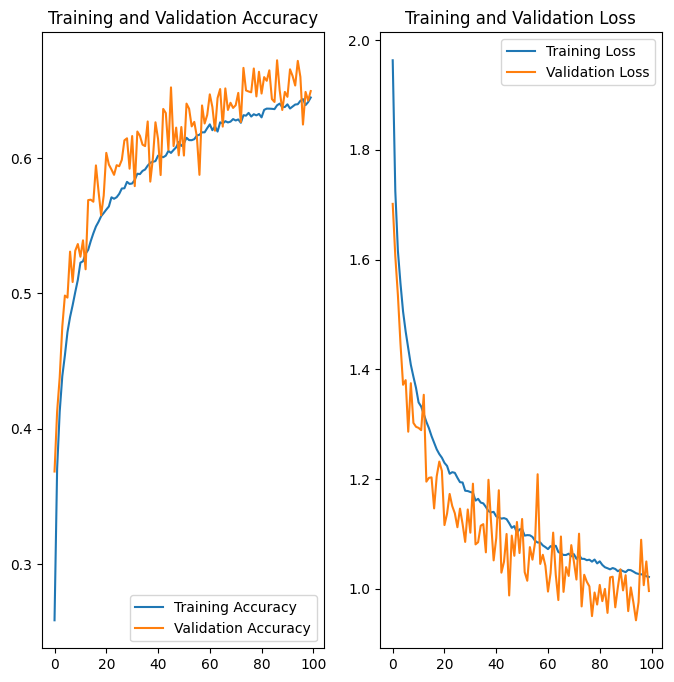

In [22]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()